In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ========== 1. 데이터 로딩 및 전처리 ==========
print("\n=== 데이터 로딩 중 ===")

# 파일 업로드 (Colab에서 실행)
from google.colab import files
uploaded = files.upload()

# 데이터 로딩
dfs = {}
for filename in ['normal_gemini.csv', 'specific_gemini.csv',
                 'normal_gpt.csv', 'specific_gpt.csv',
                 'open_source_combined.csv']:
    if filename in uploaded:
        dfs[filename] = pd.read_csv(filename)
        print(f"✓ {filename}: {len(dfs[filename])} rows")

# 데이터셋 그룹화
gemini_data = pd.concat([dfs['normal_gemini.csv'], dfs['specific_gemini.csv']], ignore_index=True)
gpt_data = pd.concat([dfs['normal_gpt.csv'], dfs['specific_gpt.csv']], ignore_index=True)
opensource_data = dfs['open_source_combined.csv']

# 소스 라벨 추가
gemini_data['source'] = 'gemini'
gpt_data['source'] = 'gpt'
opensource_data['source'] = 'opensource'

print(f"\n데이터셋 크기:")
print(f"  Gemini: {len(gemini_data)}")
print(f"  GPT: {len(gpt_data)}")
print(f"  Open Source: {len(opensource_data)}")

# 전체 데이터 합치기
all_data = pd.concat([gemini_data, gpt_data, opensource_data], ignore_index=True)

# 필요한 컬럼 확인 (텍스트와 레이블 컬럼명을 실제 데이터에 맞게 수정)
# 예시: 'text', 'label' 컬럼이 있다고 가정
text_col = 'text' if 'text' in all_data.columns else all_data.columns[0]
label_col = 'label' if 'label' in all_data.columns else all_data.columns[1]

print(f"\n사용 컬럼: 텍스트='{text_col}', 레이블='{label_col}'")

# 결측치 확인 및 처리
print(f"\n결측치 확인:")
print(f"  {text_col} 결측치: {all_data[text_col].isna().sum()}")
print(f"  {label_col} 결측치: {all_data[label_col].isna().sum()}")

# 결측치 제거
before_len = len(all_data)
all_data = all_data.dropna(subset=[text_col, label_col])
after_len = len(all_data)
print(f"  제거된 행: {before_len - after_len}개")
print(f"  남은 데이터: {after_len}개")

# 레이블을 정수로 변환 (1.0, 0.0 → 1, 0)
all_data[label_col] = all_data[label_col].astype(int)
print(f"\n레이블 타입 변환: {all_data[label_col].dtype}")
print(f"레이블 분포:\n{all_data[label_col].value_counts().sort_index()}")

# 레이블 인코딩
le = LabelEncoder()
all_data['encoded_label'] = le.fit_transform(all_data[label_col])
num_classes = len(le.classes_)
print(f"\n클래스 수: {num_classes}")
print(f"클래스: {le.classes_}")

# Train/Val/Test 분할 (stratified)
train_data, temp_data = train_test_split(
    all_data, test_size=0.3, stratify=all_data['encoded_label'], random_state=42
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, stratify=temp_data['encoded_label'], random_state=42
)

print(f"\n데이터 분할:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


=== 데이터 로딩 중 ===


Saving normal_gemini.csv to normal_gemini.csv
Saving normal_gpt.csv to normal_gpt.csv
Saving open_source_combined.csv to open_source_combined.csv
Saving specific_gemini.csv to specific_gemini.csv
Saving specific_gpt.csv to specific_gpt.csv
✓ normal_gemini.csv: 1615 rows
✓ specific_gemini.csv: 1615 rows
✓ normal_gpt.csv: 1599 rows
✓ specific_gpt.csv: 1498 rows
✓ open_source_combined.csv: 4978 rows

데이터셋 크기:
  Gemini: 3230
  GPT: 3097
  Open Source: 4978

사용 컬럼: 텍스트='dialogue', 레이블='label'

결측치 확인:
  dialogue 결측치: 1
  label 결측치: 2
  제거된 행: 2개
  남은 데이터: 11303개

레이블 타입 변환: int64
레이블 분포:
label
0    7056
1    4247
Name: count, dtype: int64

클래스 수: 2
클래스: [0 1]

데이터 분할:
  Train: 7912
  Val: 1695
  Test: 1696


In [5]:
# ========== 2. 간단한 토크나이저 및 데이터셋 ==========
class SimpleTokenizer:
    def __init__(self, max_vocab=10000):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.max_vocab = max_vocab

    def fit(self, texts):
        word_freq = {}
        for text in texts:
            for word in str(text).lower().split():
                word_freq[word] = word_freq.get(word, 0) + 1

        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        for i, (word, _) in enumerate(sorted_words[:self.max_vocab-2]):
            idx = i + 2
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, text, max_len=100):
        tokens = [self.word2idx.get(word, 1) for word in str(text).lower().split()]
        if len(tokens) < max_len:
            tokens += [0] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len]
        return tokens

# 토크나이저 학습
tokenizer = SimpleTokenizer(max_vocab=10000)
tokenizer.fit(train_data[text_col])

MAX_LEN = 100

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, text_col, max_len):
        self.texts = df[text_col].values
        self.labels = df['encoded_label'].values
        self.sources = df['source'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer.encode(self.texts[idx], self.max_len)
        return {
            'input': torch.tensor(encoded, dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'source': self.sources[idx]
        }

# 데이터셋 생성
train_dataset = TextDataset(train_data, tokenizer, text_col, MAX_LEN)
val_dataset = TextDataset(val_data, tokenizer, text_col, MAX_LEN)
test_dataset = TextDataset(test_data, tokenizer, text_col, MAX_LEN)

Vocabulary size: 10000


In [6]:
# ========== 3. LSTM 모델 정의 ==========
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        # 마지막 hidden state 사용 (양방향이므로 concat)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        dropped = self.dropout(hidden)
        output = self.fc(dropped)
        return output

In [7]:
# ========== 4. Loss Weight별 학습 함수 ==========
def train_model(model, train_loader, val_loader, loss_weights, epochs=10, lr=0.001):
    """
    loss_weights: dict {'opensource': w1, 'gemini': w2, 'gpt': w3}
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            sources = batch['source']

            optimizer.zero_grad()
            outputs = model(inputs)

            # 소스별 가중치 적용
            weights = torch.tensor([loss_weights[s] for s in sources], device=device)
            loss = criterion(outputs, labels)
            weighted_loss = (loss * weights).mean()

            weighted_loss.backward()
            optimizer.step()

            train_loss += weighted_loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input'].to(device)
                labels = batch['label'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        # 기록
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_correct / train_total)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_correct / val_total)

        print(f"Train Loss: {history['train_loss'][-1]:.4f}, "
              f"Train Acc: {history['train_acc'][-1]:.4f}, "
              f"Val Loss: {history['val_loss'][-1]:.4f}, "
              f"Val Acc: {history['val_acc'][-1]:.4f}")

    return history

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [9]:
# 하이퍼파라미터
BATCH_SIZE = 32
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3
EPOCHS = 10
LR = 0.001

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

weight_configs = [
    # 기본 설정
    {'name': 'Equal (1:1:1)', 'weights': {'opensource': 1.0, 'gemini': 1.0, 'gpt': 1.0}},

    # Open Source 중심
    {'name': 'OS-focused (1.2:1.0:0.8)', 'weights': {'opensource': 1.2, 'gemini': 1.0, 'gpt': 0.8}},
    {'name': 'OS-heavy (1.5:1.0:0.8)', 'weights': {'opensource': 1.5, 'gemini': 1.0, 'gpt': 0.8}},
    {'name': 'OS-dominant (2.0:1.0:0.5)', 'weights': {'opensource': 2.0, 'gemini': 1.0, 'gpt': 0.5}},

    # 균형잡힌 변형
    {'name': 'Balanced-A (1.1:1.0:0.9)', 'weights': {'opensource': 1.1, 'gemini': 1.0, 'gpt': 0.9}},
    {'name': 'Balanced-B (0.9:1.0:1.1)', 'weights': {'opensource': 0.9, 'gemini': 1.0, 'gpt': 1.1}},

    # 극단적 설정
    {'name': 'OS-only-emphasis (3.0:0.5:0.5)', 'weights': {'opensource': 3.0, 'gemini': 0.5, 'gpt': 0.5}},
    {'name': 'Commercial-focus (0.5:1.5:1.5)', 'weights': {'opensource': 0.5, 'gemini': 1.5, 'gpt': 1.5}},

    # 특정 조합 강조
    {'name': 'OS+Gemini (1.3:1.3:0.6)', 'weights': {'opensource': 1.3, 'gemini': 1.3, 'gpt': 0.6}},
    {'name': 'OS+GPT (1.3:0.6:1.3)', 'weights': {'opensource': 1.3, 'gemini': 0.6, 'gpt': 1.3}},
    {'name': 'Gemini+GPT (0.6:1.3:1.3)', 'weights': {'opensource': 0.6, 'gemini': 1.3, 'gpt': 1.3}},
]

results = []

for config in weight_configs:
    print(f"\n{'='*60}")
    print(f"실험: {config['name']}")
    print(f"Weights: {config['weights']}")
    print(f"{'='*60}\n")

    # 모델 초기화
    model = LSTMClassifier(
        vocab_size=len(tokenizer.word2idx),
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=num_classes,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(device)

    # 학습
    history = train_model(model, train_loader, val_loader, config['weights'], EPOCHS, LR)

    # 평가
    test_acc = evaluate_model(model, test_loader)

    # 결과와 함께 모델도 저장!
    results.append({
        'name': config['name'],
        'weights': config['weights'],
        'history': history,
        'test_acc': test_acc,
        'model': model  # ← 모델 저장 추가!
    })

    print(f"\nTest Accuracy: {test_acc:.4f}")


실험: Equal (1:1:1)
Weights: {'opensource': 1.0, 'gemini': 1.0, 'gpt': 1.0}



Epoch 1/10: 100%|██████████| 248/248 [00:06<00:00, 35.90it/s]


Train Loss: 0.2527, Train Acc: 0.8948, Val Loss: 0.1302, Val Acc: 0.9475


Epoch 2/10: 100%|██████████| 248/248 [00:05<00:00, 41.37it/s]


Train Loss: 0.0645, Train Acc: 0.9784, Val Loss: 0.0326, Val Acc: 0.9864


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 35.81it/s]


Train Loss: 0.0205, Train Acc: 0.9938, Val Loss: 0.0521, Val Acc: 0.9805


Epoch 4/10: 100%|██████████| 248/248 [00:06<00:00, 40.84it/s]


Train Loss: 0.0142, Train Acc: 0.9952, Val Loss: 0.0307, Val Acc: 0.9894


Epoch 5/10: 100%|██████████| 248/248 [00:05<00:00, 42.18it/s]


Train Loss: 0.0159, Train Acc: 0.9939, Val Loss: 0.1195, Val Acc: 0.9746


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 40.58it/s]


Train Loss: 0.0137, Train Acc: 0.9956, Val Loss: 0.0387, Val Acc: 0.9876


Epoch 7/10: 100%|██████████| 248/248 [00:06<00:00, 40.72it/s]


Train Loss: 0.0013, Train Acc: 0.9996, Val Loss: 0.0306, Val Acc: 0.9882


Epoch 8/10: 100%|██████████| 248/248 [00:05<00:00, 41.89it/s]


Train Loss: 0.0120, Train Acc: 0.9966, Val Loss: 0.0945, Val Acc: 0.9699


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 40.66it/s]


Train Loss: 0.0210, Train Acc: 0.9929, Val Loss: 0.0268, Val Acc: 0.9906


Epoch 10/10: 100%|██████████| 248/248 [00:05<00:00, 42.36it/s]


Train Loss: 0.0025, Train Acc: 0.9996, Val Loss: 0.0271, Val Acc: 0.9923

Test Accuracy: 0.9923

실험: OS-focused (1.2:1.0:0.8)
Weights: {'opensource': 1.2, 'gemini': 1.0, 'gpt': 0.8}



Epoch 1/10: 100%|██████████| 248/248 [00:06<00:00, 40.97it/s]


Train Loss: 0.2864, Train Acc: 0.8857, Val Loss: 0.1865, Val Acc: 0.9268


Epoch 2/10: 100%|██████████| 248/248 [00:05<00:00, 42.65it/s]


Train Loss: 0.0849, Train Acc: 0.9719, Val Loss: 0.0766, Val Acc: 0.9735


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 41.16it/s]


Train Loss: 0.0367, Train Acc: 0.9884, Val Loss: 0.0414, Val Acc: 0.9835


Epoch 4/10: 100%|██████████| 248/248 [00:05<00:00, 42.70it/s]


Train Loss: 0.0099, Train Acc: 0.9961, Val Loss: 0.0194, Val Acc: 0.9929


Epoch 5/10: 100%|██████████| 248/248 [00:07<00:00, 35.21it/s]


Train Loss: 0.0041, Train Acc: 0.9987, Val Loss: 0.0384, Val Acc: 0.9912


Epoch 6/10: 100%|██████████| 248/248 [00:05<00:00, 42.39it/s]


Train Loss: 0.0029, Train Acc: 0.9990, Val Loss: 0.0349, Val Acc: 0.9906


Epoch 7/10: 100%|██████████| 248/248 [00:05<00:00, 41.56it/s]


Train Loss: 0.0063, Train Acc: 0.9972, Val Loss: 0.0427, Val Acc: 0.9876


Epoch 8/10: 100%|██████████| 248/248 [00:05<00:00, 41.40it/s]


Train Loss: 0.0074, Train Acc: 0.9976, Val Loss: 0.0171, Val Acc: 0.9953


Epoch 9/10: 100%|██████████| 248/248 [00:05<00:00, 42.13it/s]


Train Loss: 0.0306, Train Acc: 0.9910, Val Loss: 0.0308, Val Acc: 0.9876


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 40.80it/s]


Train Loss: 0.0031, Train Acc: 0.9994, Val Loss: 0.0216, Val Acc: 0.9917

Test Accuracy: 0.9882

실험: OS-heavy (1.5:1.0:0.8)
Weights: {'opensource': 1.5, 'gemini': 1.0, 'gpt': 0.8}



Epoch 1/10: 100%|██████████| 248/248 [00:05<00:00, 42.61it/s]


Train Loss: 0.2974, Train Acc: 0.8922, Val Loss: 0.1385, Val Acc: 0.9481


Epoch 2/10: 100%|██████████| 248/248 [00:06<00:00, 40.93it/s]


Train Loss: 0.0815, Train Acc: 0.9754, Val Loss: 0.0974, Val Acc: 0.9687


Epoch 3/10: 100%|██████████| 248/248 [00:05<00:00, 42.69it/s]


Train Loss: 0.0412, Train Acc: 0.9879, Val Loss: 0.0687, Val Acc: 0.9782


Epoch 4/10: 100%|██████████| 248/248 [00:06<00:00, 40.76it/s]


Train Loss: 0.0201, Train Acc: 0.9947, Val Loss: 0.0814, Val Acc: 0.9699


Epoch 5/10: 100%|██████████| 248/248 [00:05<00:00, 42.95it/s]


Train Loss: 0.0213, Train Acc: 0.9939, Val Loss: 0.0409, Val Acc: 0.9870


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 41.10it/s]


Train Loss: 0.0047, Train Acc: 0.9989, Val Loss: 0.0405, Val Acc: 0.9906


Epoch 7/10: 100%|██████████| 248/248 [00:05<00:00, 42.86it/s]


Train Loss: 0.0094, Train Acc: 0.9975, Val Loss: 0.0951, Val Acc: 0.9693


Epoch 8/10: 100%|██████████| 248/248 [00:06<00:00, 41.26it/s]


Train Loss: 0.0287, Train Acc: 0.9924, Val Loss: 0.0321, Val Acc: 0.9888


Epoch 9/10: 100%|██████████| 248/248 [00:05<00:00, 41.86it/s]


Train Loss: 0.0085, Train Acc: 0.9980, Val Loss: 0.0400, Val Acc: 0.9876


Epoch 10/10: 100%|██████████| 248/248 [00:05<00:00, 42.24it/s]


Train Loss: 0.0020, Train Acc: 0.9994, Val Loss: 0.0440, Val Acc: 0.9894

Test Accuracy: 0.9929

실험: OS-dominant (2.0:1.0:0.5)
Weights: {'opensource': 2.0, 'gemini': 1.0, 'gpt': 0.5}



Epoch 1/10: 100%|██████████| 248/248 [00:06<00:00, 41.16it/s]


Train Loss: 0.3241, Train Acc: 0.8946, Val Loss: 0.1399, Val Acc: 0.9463


Epoch 2/10: 100%|██████████| 248/248 [00:05<00:00, 42.81it/s]


Train Loss: 0.0849, Train Acc: 0.9783, Val Loss: 0.0622, Val Acc: 0.9805


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 40.86it/s]


Train Loss: 0.0364, Train Acc: 0.9909, Val Loss: 0.0841, Val Acc: 0.9717


Epoch 4/10: 100%|██████████| 248/248 [00:05<00:00, 42.94it/s]


Train Loss: 0.0356, Train Acc: 0.9910, Val Loss: 0.0528, Val Acc: 0.9835


Epoch 5/10: 100%|██████████| 248/248 [00:06<00:00, 40.98it/s]


Train Loss: 0.0166, Train Acc: 0.9958, Val Loss: 0.0597, Val Acc: 0.9794


Epoch 6/10: 100%|██████████| 248/248 [00:05<00:00, 42.52it/s]


Train Loss: 0.0110, Train Acc: 0.9973, Val Loss: 0.0466, Val Acc: 0.9906


Epoch 7/10: 100%|██████████| 248/248 [00:06<00:00, 40.99it/s]


Train Loss: 0.0027, Train Acc: 0.9992, Val Loss: 0.0491, Val Acc: 0.9917


Epoch 8/10: 100%|██████████| 248/248 [00:05<00:00, 42.63it/s]


Train Loss: 0.0056, Train Acc: 0.9982, Val Loss: 0.0600, Val Acc: 0.9888


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 40.94it/s]


Train Loss: 0.0025, Train Acc: 0.9991, Val Loss: 0.0639, Val Acc: 0.9853


Epoch 10/10: 100%|██████████| 248/248 [00:05<00:00, 42.75it/s]


Train Loss: 0.0016, Train Acc: 0.9997, Val Loss: 0.0854, Val Acc: 0.9799

Test Accuracy: 0.9835

실험: Balanced-A (1.1:1.0:0.9)
Weights: {'opensource': 1.1, 'gemini': 1.0, 'gpt': 0.9}



Epoch 1/10: 100%|██████████| 248/248 [00:05<00:00, 41.93it/s]


Train Loss: 0.2171, Train Acc: 0.9077, Val Loss: 0.0803, Val Acc: 0.9705


Epoch 2/10: 100%|██████████| 248/248 [00:06<00:00, 41.22it/s]


Train Loss: 0.0627, Train Acc: 0.9784, Val Loss: 0.0544, Val Acc: 0.9823


Epoch 3/10: 100%|██████████| 248/248 [00:05<00:00, 42.55it/s]


Train Loss: 0.0248, Train Acc: 0.9919, Val Loss: 0.0461, Val Acc: 0.9835


Epoch 4/10: 100%|██████████| 248/248 [00:06<00:00, 41.10it/s]


Train Loss: 0.0234, Train Acc: 0.9938, Val Loss: 0.0492, Val Acc: 0.9835


Epoch 5/10: 100%|██████████| 248/248 [00:05<00:00, 42.64it/s]


Train Loss: 0.0153, Train Acc: 0.9953, Val Loss: 0.0283, Val Acc: 0.9876


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 40.75it/s]


Train Loss: 0.0104, Train Acc: 0.9963, Val Loss: 0.0221, Val Acc: 0.9912


Epoch 7/10: 100%|██████████| 248/248 [00:05<00:00, 42.48it/s]


Train Loss: 0.0027, Train Acc: 0.9992, Val Loss: 0.0378, Val Acc: 0.9888


Epoch 8/10: 100%|██████████| 248/248 [00:06<00:00, 40.93it/s]


Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0326, Val Acc: 0.9912


Epoch 9/10: 100%|██████████| 248/248 [00:05<00:00, 42.73it/s]


Train Loss: 0.0062, Train Acc: 0.9973, Val Loss: 0.0375, Val Acc: 0.9894


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 40.82it/s]


Train Loss: 0.0074, Train Acc: 0.9977, Val Loss: 0.1208, Val Acc: 0.9735

Test Accuracy: 0.9723

실험: Balanced-B (0.9:1.0:1.1)
Weights: {'opensource': 0.9, 'gemini': 1.0, 'gpt': 1.1}



Epoch 1/10: 100%|██████████| 248/248 [00:05<00:00, 42.73it/s]


Train Loss: 0.2116, Train Acc: 0.9080, Val Loss: 0.0664, Val Acc: 0.9776


Epoch 2/10: 100%|██████████| 248/248 [00:06<00:00, 41.31it/s]


Train Loss: 0.0821, Train Acc: 0.9692, Val Loss: 0.0985, Val Acc: 0.9664


Epoch 3/10: 100%|██████████| 248/248 [00:05<00:00, 41.97it/s]


Train Loss: 0.0484, Train Acc: 0.9832, Val Loss: 0.0783, Val Acc: 0.9794


Epoch 4/10: 100%|██████████| 248/248 [00:05<00:00, 42.03it/s]


Train Loss: 0.0234, Train Acc: 0.9933, Val Loss: 0.0529, Val Acc: 0.9835


Epoch 5/10: 100%|██████████| 248/248 [00:06<00:00, 40.73it/s]


Train Loss: 0.0493, Train Acc: 0.9839, Val Loss: 0.0658, Val Acc: 0.9817


Epoch 6/10: 100%|██████████| 248/248 [00:05<00:00, 42.56it/s]


Train Loss: 0.0100, Train Acc: 0.9961, Val Loss: 0.0337, Val Acc: 0.9900


Epoch 7/10: 100%|██████████| 248/248 [00:06<00:00, 40.81it/s]


Train Loss: 0.0012, Train Acc: 0.9997, Val Loss: 0.0564, Val Acc: 0.9876


Epoch 8/10: 100%|██████████| 248/248 [00:05<00:00, 42.56it/s]


Train Loss: 0.0048, Train Acc: 0.9982, Val Loss: 0.0424, Val Acc: 0.9876


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 40.64it/s]


Train Loss: 0.0019, Train Acc: 0.9995, Val Loss: 0.0245, Val Acc: 0.9923


Epoch 10/10: 100%|██████████| 248/248 [00:05<00:00, 42.42it/s]


Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0457, Val Acc: 0.9894

Test Accuracy: 0.9912

실험: OS-only-emphasis (3.0:0.5:0.5)
Weights: {'opensource': 3.0, 'gemini': 0.5, 'gpt': 0.5}



Epoch 1/10: 100%|██████████| 248/248 [00:06<00:00, 40.44it/s]


Train Loss: 0.3927, Train Acc: 0.8933, Val Loss: 0.1077, Val Acc: 0.9652


Epoch 2/10: 100%|██████████| 248/248 [00:05<00:00, 42.31it/s]


Train Loss: 0.1338, Train Acc: 0.9694, Val Loss: 0.0639, Val Acc: 0.9788


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 40.44it/s]


Train Loss: 0.0471, Train Acc: 0.9901, Val Loss: 0.0309, Val Acc: 0.9906


Epoch 4/10: 100%|██████████| 248/248 [00:05<00:00, 41.45it/s]


Train Loss: 0.0193, Train Acc: 0.9956, Val Loss: 0.0363, Val Acc: 0.9864


Epoch 5/10: 100%|██████████| 248/248 [00:05<00:00, 41.60it/s]


Train Loss: 0.0175, Train Acc: 0.9963, Val Loss: 0.0461, Val Acc: 0.9864


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 40.51it/s]


Train Loss: 0.0031, Train Acc: 0.9996, Val Loss: 0.0267, Val Acc: 0.9941


Epoch 7/10: 100%|██████████| 248/248 [00:05<00:00, 41.86it/s]


Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0289, Val Acc: 0.9935


Epoch 8/10: 100%|██████████| 248/248 [00:06<00:00, 40.25it/s]


Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0297, Val Acc: 0.9941


Epoch 9/10: 100%|██████████| 248/248 [00:05<00:00, 41.71it/s]


Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0320, Val Acc: 0.9941


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 37.18it/s]


Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0322, Val Acc: 0.9941

Test Accuracy: 0.9917

실험: Commercial-focus (0.5:1.5:1.5)
Weights: {'opensource': 0.5, 'gemini': 1.5, 'gpt': 1.5}



Epoch 1/10: 100%|██████████| 248/248 [00:05<00:00, 41.70it/s]


Train Loss: 0.2649, Train Acc: 0.8898, Val Loss: 0.1174, Val Acc: 0.9522


Epoch 2/10: 100%|██████████| 248/248 [00:06<00:00, 38.60it/s]


Train Loss: 0.0664, Train Acc: 0.9789, Val Loss: 0.1240, Val Acc: 0.9587


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 40.25it/s]


Train Loss: 0.0266, Train Acc: 0.9919, Val Loss: 0.0337, Val Acc: 0.9853


Epoch 4/10: 100%|██████████| 248/248 [00:06<00:00, 40.10it/s]


Train Loss: 0.0322, Train Acc: 0.9909, Val Loss: 0.0435, Val Acc: 0.9841


Epoch 5/10: 100%|██████████| 248/248 [00:06<00:00, 36.99it/s]


Train Loss: 0.0070, Train Acc: 0.9977, Val Loss: 0.0926, Val Acc: 0.9776


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 39.43it/s]


Train Loss: 0.0161, Train Acc: 0.9939, Val Loss: 0.0339, Val Acc: 0.9923


Epoch 7/10: 100%|██████████| 248/248 [00:06<00:00, 38.26it/s]


Train Loss: 0.0094, Train Acc: 0.9968, Val Loss: 0.0263, Val Acc: 0.9912


Epoch 8/10: 100%|██████████| 248/248 [00:06<00:00, 40.66it/s]


Train Loss: 0.0029, Train Acc: 0.9991, Val Loss: 0.0318, Val Acc: 0.9923


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 39.05it/s]


Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0428, Val Acc: 0.9912


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 41.03it/s]


Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0486, Val Acc: 0.9906

Test Accuracy: 0.9888

실험: OS+Gemini (1.3:1.3:0.6)
Weights: {'opensource': 1.3, 'gemini': 1.3, 'gpt': 0.6}



Epoch 1/10: 100%|██████████| 248/248 [00:06<00:00, 40.18it/s]


Train Loss: 0.2766, Train Acc: 0.8917, Val Loss: 0.2064, Val Acc: 0.9286


Epoch 2/10: 100%|██████████| 248/248 [00:06<00:00, 38.86it/s]


Train Loss: 0.0918, Train Acc: 0.9716, Val Loss: 0.0542, Val Acc: 0.9841


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 40.66it/s]


Train Loss: 0.0388, Train Acc: 0.9889, Val Loss: 0.0347, Val Acc: 0.9882


Epoch 4/10: 100%|██████████| 248/248 [00:06<00:00, 39.25it/s]


Train Loss: 0.0165, Train Acc: 0.9943, Val Loss: 0.0418, Val Acc: 0.9847


Epoch 5/10: 100%|██████████| 248/248 [00:06<00:00, 41.19it/s]


Train Loss: 0.0069, Train Acc: 0.9982, Val Loss: 0.0546, Val Acc: 0.9858


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 39.25it/s]


Train Loss: 0.0050, Train Acc: 0.9982, Val Loss: 0.0426, Val Acc: 0.9888


Epoch 7/10: 100%|██████████| 248/248 [00:06<00:00, 41.14it/s]


Train Loss: 0.0218, Train Acc: 0.9936, Val Loss: 0.0573, Val Acc: 0.9823


Epoch 8/10: 100%|██████████| 248/248 [00:06<00:00, 39.10it/s]


Train Loss: 0.0133, Train Acc: 0.9952, Val Loss: 0.0215, Val Acc: 0.9935


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 40.99it/s]


Train Loss: 0.0029, Train Acc: 0.9990, Val Loss: 0.0298, Val Acc: 0.9935


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 40.15it/s]


Train Loss: 0.0041, Train Acc: 0.9990, Val Loss: 0.0239, Val Acc: 0.9935

Test Accuracy: 0.9941

실험: OS+GPT (1.3:0.6:1.3)
Weights: {'opensource': 1.3, 'gemini': 0.6, 'gpt': 1.3}



Epoch 1/10: 100%|██████████| 248/248 [00:06<00:00, 39.67it/s]


Train Loss: 0.2480, Train Acc: 0.9018, Val Loss: 0.0824, Val Acc: 0.9735


Epoch 2/10: 100%|██████████| 248/248 [00:05<00:00, 41.58it/s]


Train Loss: 0.0887, Train Acc: 0.9706, Val Loss: 0.0819, Val Acc: 0.9687


Epoch 3/10: 100%|██████████| 248/248 [00:06<00:00, 39.56it/s]


Train Loss: 0.0581, Train Acc: 0.9814, Val Loss: 0.0500, Val Acc: 0.9841


Epoch 4/10: 100%|██████████| 248/248 [00:05<00:00, 41.70it/s]


Train Loss: 0.0221, Train Acc: 0.9938, Val Loss: 0.0445, Val Acc: 0.9906


Epoch 5/10: 100%|██████████| 248/248 [00:06<00:00, 39.67it/s]


Train Loss: 0.0079, Train Acc: 0.9977, Val Loss: 0.0306, Val Acc: 0.9917


Epoch 6/10: 100%|██████████| 248/248 [00:05<00:00, 41.42it/s]


Train Loss: 0.0063, Train Acc: 0.9982, Val Loss: 0.0402, Val Acc: 0.9906


Epoch 7/10: 100%|██████████| 248/248 [00:06<00:00, 39.34it/s]


Train Loss: 0.0044, Train Acc: 0.9990, Val Loss: 0.0700, Val Acc: 0.9841


Epoch 8/10: 100%|██████████| 248/248 [00:05<00:00, 41.67it/s]


Train Loss: 0.0071, Train Acc: 0.9980, Val Loss: 0.0421, Val Acc: 0.9923


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 40.39it/s]


Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.0427, Val Acc: 0.9923


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 40.50it/s]


Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0459, Val Acc: 0.9923

Test Accuracy: 0.9900

실험: Gemini+GPT (0.6:1.3:1.3)
Weights: {'opensource': 0.6, 'gemini': 1.3, 'gpt': 1.3}



Epoch 1/10: 100%|██████████| 248/248 [00:05<00:00, 41.57it/s]


Train Loss: 0.2438, Train Acc: 0.8916, Val Loss: 0.0681, Val Acc: 0.9770


Epoch 2/10: 100%|██████████| 248/248 [00:06<00:00, 39.63it/s]


Train Loss: 0.0574, Train Acc: 0.9805, Val Loss: 0.0508, Val Acc: 0.9835


Epoch 3/10: 100%|██████████| 248/248 [00:05<00:00, 41.64it/s]


Train Loss: 0.0214, Train Acc: 0.9925, Val Loss: 0.1003, Val Acc: 0.9729


Epoch 4/10: 100%|██████████| 248/248 [00:06<00:00, 39.67it/s]


Train Loss: 0.0140, Train Acc: 0.9949, Val Loss: 0.0335, Val Acc: 0.9917


Epoch 5/10: 100%|██████████| 248/248 [00:05<00:00, 41.53it/s]


Train Loss: 0.0169, Train Acc: 0.9944, Val Loss: 0.0377, Val Acc: 0.9917


Epoch 6/10: 100%|██████████| 248/248 [00:06<00:00, 39.38it/s]


Train Loss: 0.0110, Train Acc: 0.9962, Val Loss: 0.0401, Val Acc: 0.9858


Epoch 7/10: 100%|██████████| 248/248 [00:05<00:00, 41.83it/s]


Train Loss: 0.0063, Train Acc: 0.9984, Val Loss: 0.0337, Val Acc: 0.9870


Epoch 8/10: 100%|██████████| 248/248 [00:06<00:00, 39.77it/s]


Train Loss: 0.0055, Train Acc: 0.9982, Val Loss: 0.0341, Val Acc: 0.9882


Epoch 9/10: 100%|██████████| 248/248 [00:06<00:00, 40.86it/s]


Train Loss: 0.0041, Train Acc: 0.9987, Val Loss: 0.0133, Val Acc: 0.9971


Epoch 10/10: 100%|██████████| 248/248 [00:06<00:00, 40.77it/s]


Train Loss: 0.0109, Train Acc: 0.9962, Val Loss: 0.0422, Val Acc: 0.9847

Test Accuracy: 0.9788


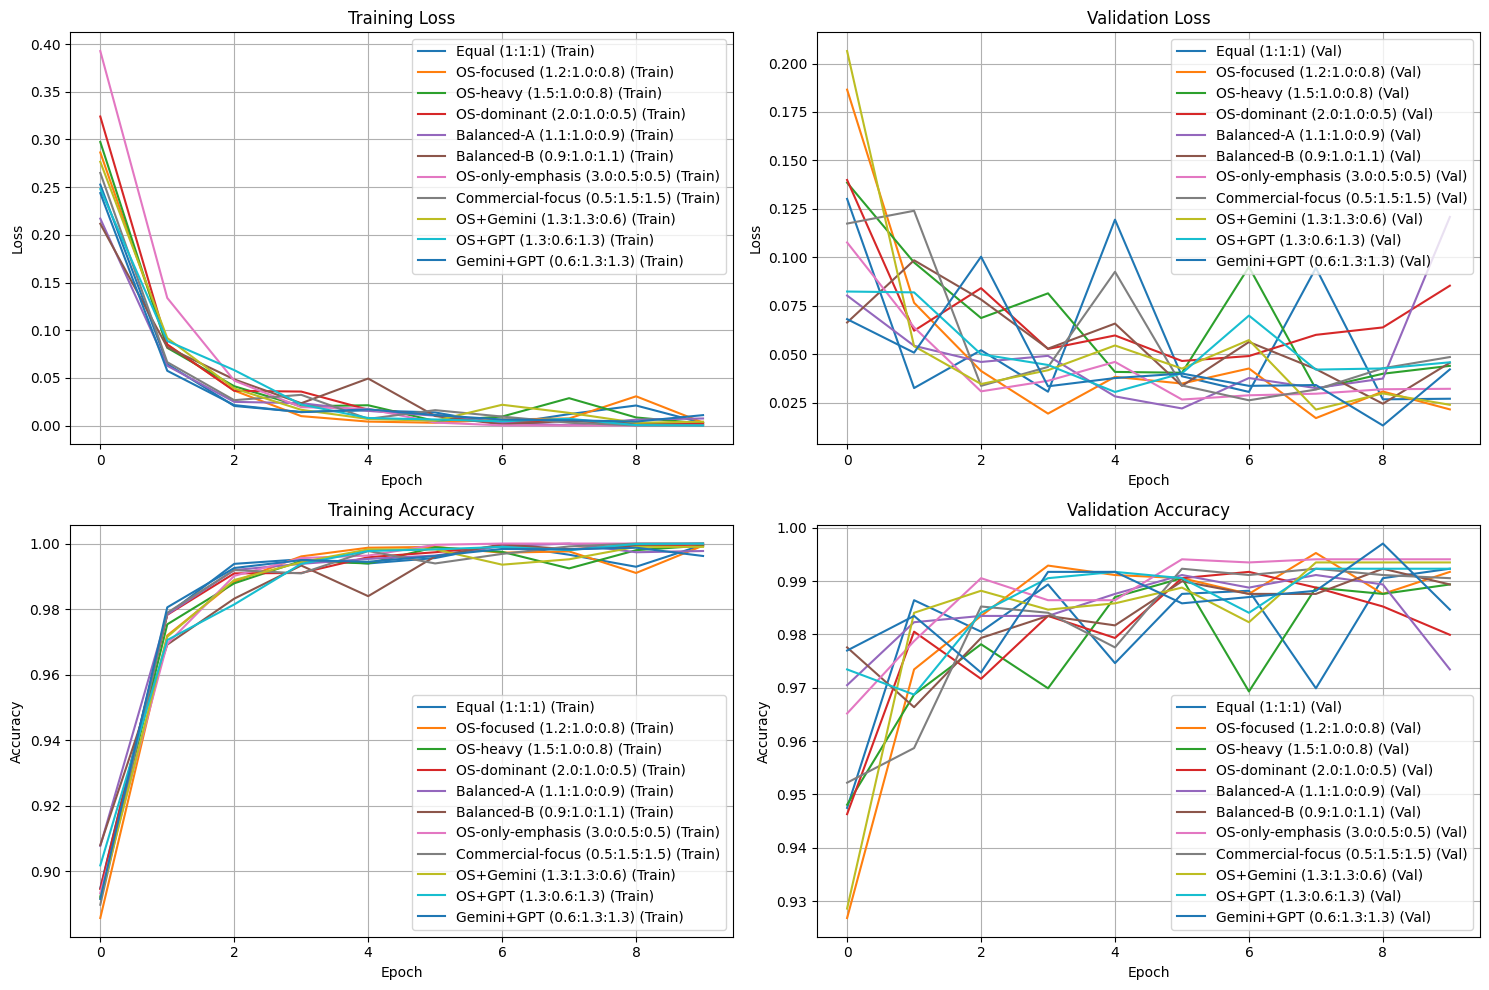

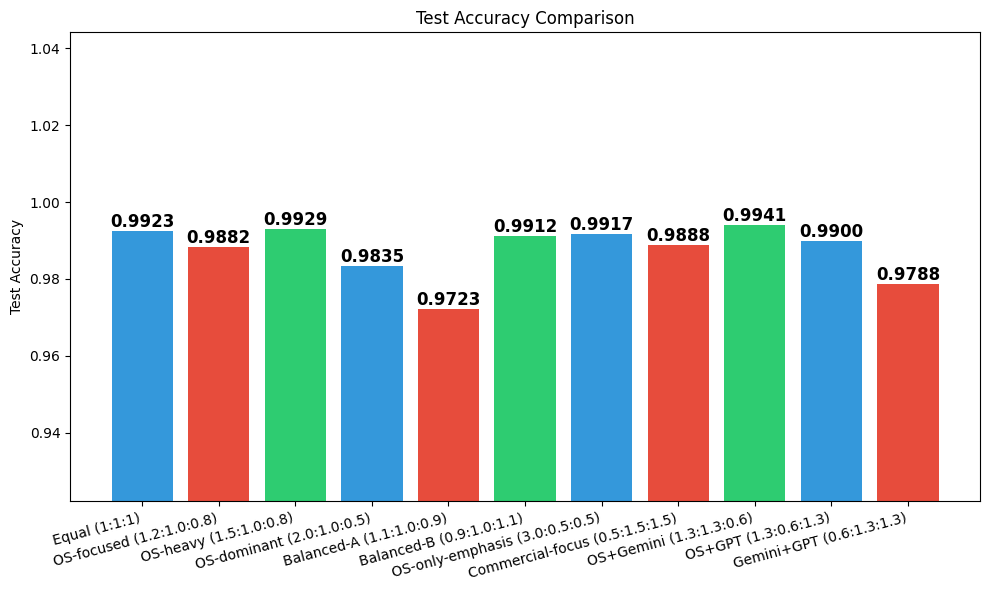

In [10]:
# ========== 6. 결과 시각화 ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss 비교
for result in results:
    axes[0, 0].plot(result['history']['train_loss'], label=f"{result['name']} (Train)")
    axes[0, 1].plot(result['history']['val_loss'], label=f"{result['name']} (Val)")

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy 비교
for result in results:
    axes[1, 0].plot(result['history']['train_acc'], label=f"{result['name']} (Train)")
    axes[1, 1].plot(result['history']['val_acc'], label=f"{result['name']} (Val)")

axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Test Accuracy 막대그래프
fig, ax = plt.subplots(figsize=(10, 6))
names = [r['name'] for r in results]
test_accs = [r['test_acc'] for r in results]

bars = ax.bar(names, test_accs, color=['#3498db', '#e74c3c', '#2ecc71'])
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy Comparison')
ax.set_ylim([min(test_accs) - 0.05, max(test_accs) + 0.05])

# 막대 위에 값 표시
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# ========== 7. 최종 결과 요약 ==========
print("\n" + "="*60)
print("최종 결과 요약")
print("="*60)
for result in results:
    print(f"\n{result['name']}")
    print(f"  Loss Weights: {result['weights']}")
    print(f"  Final Val Acc: {result['history']['val_acc'][-1]:.4f}")
    print(f"  Test Acc: {result['test_acc']:.4f}")

best_result = max(results, key=lambda x: x['test_acc'])
print(f"\n🏆 Best Configuration: {best_result['name']}")
print(f"   Test Accuracy: {best_result['test_acc']:.4f}")


최종 결과 요약

Equal (1:1:1)
  Loss Weights: {'opensource': 1.0, 'gemini': 1.0, 'gpt': 1.0}
  Final Val Acc: 0.9923
  Test Acc: 0.9923

OS-focused (1.2:1.0:0.8)
  Loss Weights: {'opensource': 1.2, 'gemini': 1.0, 'gpt': 0.8}
  Final Val Acc: 0.9917
  Test Acc: 0.9882

OS-heavy (1.5:1.0:0.8)
  Loss Weights: {'opensource': 1.5, 'gemini': 1.0, 'gpt': 0.8}
  Final Val Acc: 0.9894
  Test Acc: 0.9929

OS-dominant (2.0:1.0:0.5)
  Loss Weights: {'opensource': 2.0, 'gemini': 1.0, 'gpt': 0.5}
  Final Val Acc: 0.9799
  Test Acc: 0.9835

Balanced-A (1.1:1.0:0.9)
  Loss Weights: {'opensource': 1.1, 'gemini': 1.0, 'gpt': 0.9}
  Final Val Acc: 0.9735
  Test Acc: 0.9723

Balanced-B (0.9:1.0:1.1)
  Loss Weights: {'opensource': 0.9, 'gemini': 1.0, 'gpt': 1.1}
  Final Val Acc: 0.9894
  Test Acc: 0.9912

OS-only-emphasis (3.0:0.5:0.5)
  Loss Weights: {'opensource': 3.0, 'gemini': 0.5, 'gpt': 0.5}
  Final Val Acc: 0.9941
  Test Acc: 0.9917

Commercial-focus (0.5:1.5:1.5)
  Loss Weights: {'opensource': 0.5, 'gem

In [12]:
# ========== 8. 점진적 추론 (Progressive Inference) - 수정 버전 ==========
print("\n" + "="*60)
print("점진적 추론 분석 시작")
print("="*60)

def progressive_inference(model, test_dataset, percentages=range(1, 101)):
    """
    테스트 데이터를 점진적으로 입력하여 성능 측정

    Args:
        model: 학습된 모델
        test_dataset: 테스트 데이터셋
        percentages: 분석할 퍼센트 리스트 (기본: 1~100%)

    Returns:
        results: 각 퍼센트별 정확도 딕셔너리
    """
    model.eval()
    results = []

    total_samples = len(test_dataset)

    for pct in tqdm(percentages, desc="Progressive Inference"):
        # 현재 퍼센트까지의 데이터만 사용
        num_samples = int(total_samples * pct / 100)
        if num_samples == 0:
            continue

        correct = 0
        total = 0

        with torch.no_grad():
            for idx in range(num_samples):
                sample = test_dataset[idx]
                inputs = sample['input'].unsqueeze(0).to(device)
                label = sample['label'].to(device)

                # 점진적 입력: 시퀀스를 현재 퍼센트까지만 사용
                seq_len = inputs.size(1)
                truncated_len = max(1, int(seq_len * pct / 100))
                truncated_input = inputs[:, :truncated_len]

                # 패딩 추가 (원래 길이 유지)
                if truncated_len < seq_len:
                    padding = torch.zeros(1, seq_len - truncated_len, dtype=torch.long, device=device)
                    truncated_input = torch.cat([truncated_input, padding], dim=1)

                outputs = model(truncated_input)
                pred = outputs.argmax(1)

                correct += (pred == label).sum().item()
                total += 1

        accuracy = correct / total if total > 0 else 0
        results.append({
            'percentage': pct,
            'accuracy': accuracy,
            'num_samples': num_samples
        })

    return results

# Best 모델 선택
best_model_idx = np.argmax([r['test_acc'] for r in results])
best_model_name = results[best_model_idx]['name']
best_model = results[best_model_idx]['model']  # ← Best 모델 선택!
best_test_acc = results[best_model_idx]['test_acc']

print(f"\n🏆 최고 성능 모델: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f}")
print("   이 모델로 점진적 추론을 수행합니다...\n")

# 점진적 추론 실행 (1~100%, 1% 단위)
progressive_results = progressive_inference(best_model, test_dataset, percentages=range(1, 101))

# 결과를 DataFrame으로 변환
prog_df = pd.DataFrame(progressive_results)


점진적 추론 분석 시작

🏆 최고 성능 모델: OS+Gemini (1.3:1.3:0.6)
   Test Accuracy: 0.9941
   이 모델로 점진적 추론을 수행합니다...



Progressive Inference: 100%|██████████| 100/100 [06:27<00:00,  3.87s/it]


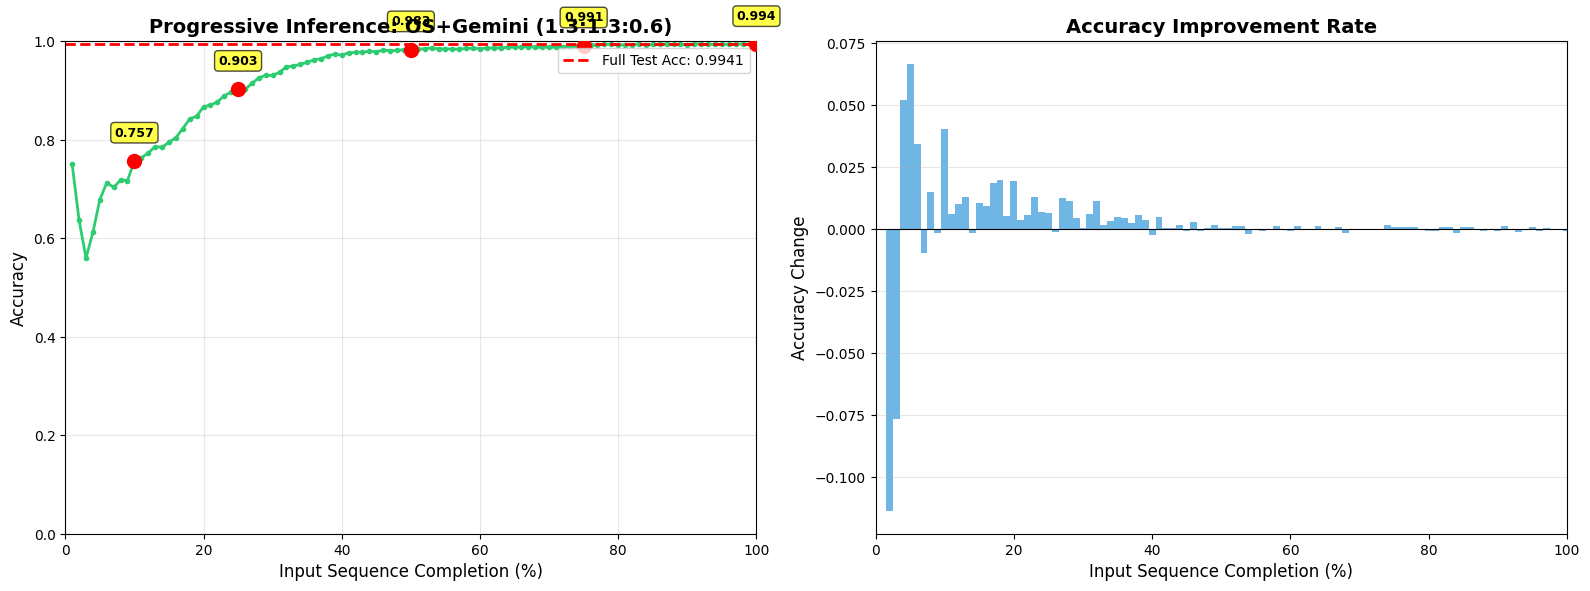

In [13]:
# ========== 9. 점진적 추론 시각화 ==========
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) 정확도 변화 그래프
axes[0].plot(prog_df['percentage'], prog_df['accuracy'],
             linewidth=2, color='#2ecc71', marker='o', markersize=3)
axes[0].axhline(y=best_test_acc,
                color='r', linestyle='--', linewidth=2,
                label=f'Full Test Acc: {best_test_acc:.4f}')
axes[0].set_xlabel('Input Sequence Completion (%)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title(f'Progressive Inference: {best_model_name}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xlim([0, 100])
axes[0].set_ylim([0, 1])

# 주요 마일스톤 표시
milestones = [10, 25, 50, 75, 100]
for ms in milestones:
    if ms <= len(prog_df):
        ms_acc = prog_df[prog_df['percentage'] == ms]['accuracy'].values[0]
        axes[0].scatter([ms], [ms_acc], s=100, c='red', zorder=5)
        axes[0].annotate(f'{ms_acc:.3f}',
                        xy=(ms, ms_acc),
                        xytext=(ms, ms_acc + 0.05),
                        ha='center', fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 2) 정확도 증가율 그래프
prog_df['acc_diff'] = prog_df['accuracy'].diff().fillna(0)
axes[1].bar(prog_df['percentage'], prog_df['acc_diff'],
            color='#3498db', alpha=0.7, width=1)
axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].set_xlabel('Input Sequence Completion (%)', fontsize=12)
axes[1].set_ylabel('Accuracy Change', fontsize=12)
axes[1].set_title('Accuracy Improvement Rate', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xlim([0, 100])

plt.tight_layout()
plt.savefig('progressive_inference_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# ========== 10. 주요 통계 출력 (1% 단위 상세 버전) ==========
print("\n" + "="*60)
print("점진적 추론 주요 통계")
print("="*60)

# 50% 정확도 도달 지점
target_acc = best_test_acc * 0.5
reach_50_pct = prog_df[prog_df['accuracy'] >= target_acc]['percentage'].min()
print(f"\n50% 목표 정확도 도달: {reach_50_pct}% 입력")

# 80% 정확도 도달 지점
target_acc_80 = best_test_acc * 0.8
reach_80_pct = prog_df[prog_df['accuracy'] >= target_acc_80]['percentage'].min()
print(f"80% 목표 정확도 도달: {reach_80_pct}% 입력")

# 90% 정확도 도달 지점
target_acc_90 = best_test_acc * 0.9
reach_90_pct = prog_df[prog_df['accuracy'] >= target_acc_90]['percentage'].min()
print(f"90% 목표 정확도 도달: {reach_90_pct}% 입력")

# 1% 단위 전체 정확도 표시
print("\n" + "="*60)
print("1% 단위 정확도 상세 리포트")
print("="*60)
print(f"{'입력%':>5} | {'정확도':>8} | {'변화량':>8} | 비주얼")
print("-" * 60)

for idx, row in prog_df.iterrows():
    pct = int(row['percentage'])
    acc = row['accuracy']
    diff = row['acc_diff']

    # 정확도를 바 그래프로 시각화 (50칸 기준)
    bar_length = int(acc * 50)
    bar = '█' * bar_length + '░' * (50 - bar_length)

    # 변화량 표시
    diff_str = f"+{diff:.4f}" if diff >= 0 else f"{diff:.4f}"

    # 특정 구간 강조
    marker = ""
    if pct in [10, 25, 50, 75, 100]:
        marker = " ⭐"
    elif pct == reach_50_pct:
        marker = " 🎯 50%"
    elif pct == reach_80_pct:
        marker = " 🎯 80%"
    elif pct == reach_90_pct:
        marker = " 🎯 90%"

    print(f"{pct:4d}% | {acc:8.4f} | {diff_str:>8} | {bar[:25]}{marker}")

# 가장 큰 정확도 향상 구간
max_improvement_idx = prog_df['acc_diff'].idxmax()
max_improvement_pct = prog_df.loc[max_improvement_idx, 'percentage']
max_improvement_val = prog_df.loc[max_improvement_idx, 'acc_diff']
print("\n" + "="*60)
print(f"최대 정확도 향상 구간: {int(max_improvement_pct-1)}% → {int(max_improvement_pct)}%")
print(f"향상 폭: +{max_improvement_val:.4f}")

# 구간별 평균 향상률
print("\n구간별 평균 정확도 향상률:")
intervals = [(1, 10), (11, 25), (26, 50), (51, 75), (76, 100)]
for start, end in intervals:
    interval_data = prog_df[(prog_df['percentage'] >= start) & (prog_df['percentage'] <= end)]
    avg_improvement = interval_data['acc_diff'].mean()
    print(f"  {start:3d}~{end:3d}%: 평균 +{avg_improvement:.5f} per 1%")

# 안정화 구간 분석 (마지막 10% 구간의 평균 변화)
last_10_pct = prog_df[prog_df['percentage'] >= 90]
avg_change = last_10_pct['acc_diff'].abs().mean()
print(f"\n마지막 10% 구간 평균 변화: {avg_change:.6f}")
print(f"(낮을수록 조기에 안정적인 예측 가능)")

# 초반 성능 (10% 입력 시)
early_acc = prog_df[prog_df['percentage'] == 10]['accuracy'].values[0]
early_ratio = early_acc / best_test_acc
print(f"\n초반 성능 비율 (10% 입력 / 100% 입력): {early_ratio:.2%}")

# 추가 통계: 정확도 95%, 98% 도달 지점
target_acc_95 = best_test_acc * 0.95
reach_95_pct = prog_df[prog_df['accuracy'] >= target_acc_95]['percentage'].min()
target_acc_98 = best_test_acc * 0.98
reach_98_pct = prog_df[prog_df['accuracy'] >= target_acc_98]['percentage'].min()
print(f"\n추가 마일스톤:")
print(f"  95% 목표 정확도 도달: {reach_95_pct}% 입력")
print(f"  98% 목표 정확도 도달: {reach_98_pct}% 입력")

# 효율성 지표
print(f"\n💡 효율성 분석:")
acc_50 = prog_df[prog_df['percentage'] == 50]['accuracy'].values[0]
efficiency_50 = (acc_50 / best_test_acc) * 100
print(f"  50% 입력으로 달성 가능한 성능: {efficiency_50:.2f}%")
print(f"  → 전체 데이터의 절반만으로 최종 성능의 {efficiency_50:.1f}% 달성")

acc_25 = prog_df[prog_df['percentage'] == 25]['accuracy'].values[0]
efficiency_25 = (acc_25 / best_test_acc) * 100
print(f"  25% 입력으로 달성 가능한 성능: {efficiency_25:.2f}%")
print(f"  → 전체 데이터의 1/4만으로 최종 성능의 {efficiency_25:.1f}% 달성")

print("\n" + "="*60)
print(f"✅ 점진적 추론 완료 - {best_model_name} 모델 사용")
print("="*60)


점진적 추론 주요 통계

50% 목표 정확도 도달: 1% 입력
80% 목표 정확도 도달: 16% 입력
90% 목표 정확도 도달: 24% 입력

1% 단위 정확도 상세 리포트
  입력% |      정확도 |      변화량 | 비주얼
------------------------------------------------------------
   1% |   0.7500 |  +0.0000 | █████████████████████████ 🎯 50%
   2% |   0.6364 |  -0.1136 | █████████████████████████
   3% |   0.5600 |  -0.0764 | █████████████████████████
   4% |   0.6119 |  +0.0519 | █████████████████████████
   5% |   0.6786 |  +0.0666 | █████████████████████████
   6% |   0.7129 |  +0.0343 | █████████████████████████
   7% |   0.7034 |  -0.0095 | █████████████████████████
   8% |   0.7185 |  +0.0151 | █████████████████████████
   9% |   0.7171 |  -0.0014 | █████████████████████████
  10% |   0.7574 |  +0.0403 | █████████████████████████ ⭐
  11% |   0.7634 |  +0.0060 | █████████████████████████
  12% |   0.7734 |  +0.0100 | █████████████████████████
  13% |   0.7864 |  +0.0130 | █████████████████████████
  14% |   0.7848 |  -0.0016 | █████████████████████████
  15% |   0.795